In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pickle


In [15]:
# Load ALREADY-SPLIT datasets (SOURCE OF TRUTH)
train_df = pd.read_csv(r"C:\Users\PORTABLE\Desktop\projet_annuel\core/plank_model/data/plank_train_full.csv")
test_df  = pd.read_csv(r"C:\Users\PORTABLE\Desktop\projet_annuel\core/plank_model/data/plank_test_full.csv")

train_df, val_df = train_test_split(
    train_df,
    test_size=0.15,
    stratify=train_df["label"],
    random_state=42
)


X_train = train_df.drop("label", axis=1).values.astype(np.float32)
y_train = train_df["label"].values.astype(np.float32)

X_val = val_df.drop("label", axis=1).values.astype(np.float32)
y_val = val_df["label"].values.astype(np.float32)

X_test = test_df.drop("label", axis=1).values.astype(np.float32)
y_test = test_df["label"].values.astype(np.float32)

# Fit scaler ONLY on TRAIN
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# Save scaler for live
with open(r"C:\Users\PORTABLE\Desktop\projet_annuel\core/plank_model/model/scaler_full.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)




In [16]:
# SANITY CHECK
print("TRAIN:", X_train.shape, "VAL:", X_val.shape, "TEST:", X_test.shape)
print("Label distrib train:", np.unique(y_train.numpy(), return_counts=True))
print("Label distrib val  :", np.unique(y_val.numpy(), return_counts=True))
print("Label distrib test :", np.unique(y_test.numpy(), return_counts=True))

print("TRAIN SHAPE:", X_train.shape)
print("TEST  SHAPE:", X_test.shape)
print("TRAIN LABELS:", np.unique(y_train.numpy(), return_counts=True))
print("TEST  LABELS:", np.unique(y_test.numpy(), return_counts=True))
print("NaNs:", np.isnan(X_train.numpy()).any())
print("Infs:", np.isinf(X_train.numpy()).any())

TRAIN: torch.Size([2418, 132]) VAL: torch.Size([427, 132]) TEST: torch.Size([1090, 132])
Label distrib train: (array([0., 1.], dtype=float32), array([1832,  586]))
Label distrib val  : (array([0., 1.], dtype=float32), array([323, 104]))
Label distrib test : (array([0., 1.], dtype=float32), array([526, 564]))
TRAIN SHAPE: torch.Size([2418, 132])
TEST  SHAPE: torch.Size([1090, 132])
TRAIN LABELS: (array([0., 1.], dtype=float32), array([1832,  586]))
TEST  LABELS: (array([0., 1.], dtype=float32), array([526, 564]))
NaNs: False
Infs: False


In [17]:
class MLP_Full(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP_Full(input_dim=X_train.shape[1])


In [18]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [19]:
EPOCHS = 20

train_losses, val_losses = [], []

for epoch in range(EPOCHS):

    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        preds = model(xb).squeeze()
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb).squeeze()
            val_loss += loss_fn(pred, yb).item()

    train_losses.append(total_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))

    print(f"{epoch+1}: train={train_losses[-1]:.4f} | val={val_losses[-1]:.4f}")


1: train=0.2767 | val=0.0420
2: train=0.0364 | val=0.0168
3: train=0.0188 | val=0.0073
4: train=0.0145 | val=0.0035
5: train=0.0066 | val=0.0010
6: train=0.0021 | val=0.0004
7: train=0.0017 | val=0.0003
8: train=0.0019 | val=0.0001
9: train=0.0028 | val=0.0001
10: train=0.0006 | val=0.0001
11: train=0.0043 | val=0.0002
12: train=0.0011 | val=0.0001
13: train=0.0066 | val=0.0002
14: train=0.0024 | val=0.0002
15: train=0.0011 | val=0.0001
16: train=0.0005 | val=0.0000
17: train=0.0011 | val=0.0000
18: train=0.0002 | val=0.0000
19: train=0.0001 | val=0.0000
20: train=0.0023 | val=0.0009


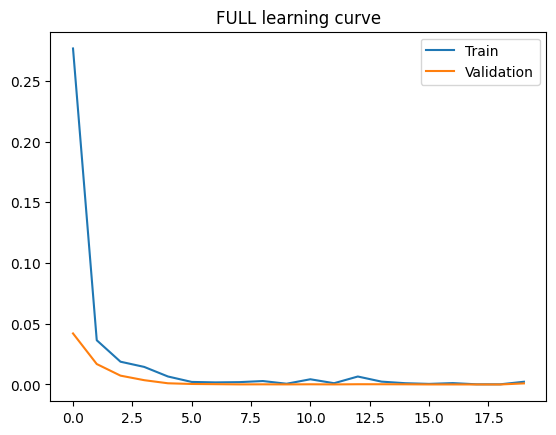

In [20]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Train","Validation"])
plt.title("FULL learning curve")
plt.show()

In [21]:
torch.save(model.state_dict(), r"C:\Users\PORTABLE\Desktop\projet_annuel\core\plank_model\model\plank_mlp_full.pt")
print("Modèle FULL sauvegardé.")

Modèle FULL sauvegardé.


In [22]:
model.eval()
with torch.no_grad():
    preds = torch.sigmoid(model(X_test)).squeeze()
    preds = (preds > 0.5).float()
    acc = (preds == y_test).float().mean().item()

print("FINAL TEST ACCURACY:", acc)


FINAL TEST ACCURACY: 0.8018348813056946
